In [1]:
import os
from sys import stdout
import time

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
import scipy.io
from sklearn import model_selection
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV
from deap import base
from deap import creator
from deap import tools

from feature_selection import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
x_df = pd.read_csv('data_full.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))


(32051, 4094)
(4094,)
32051


In [7]:
values[0]

array([ 582.463687,  504.208566,  530.709497, ..., 2177.945996,
       1990.074488, 1936.068901])

[188.1951 188.2601 188.325  ... 440.6714 440.7245 440.7775]


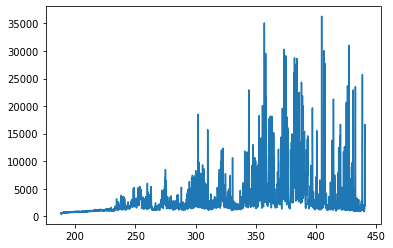

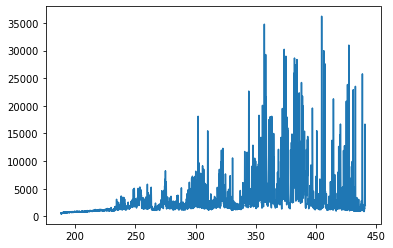

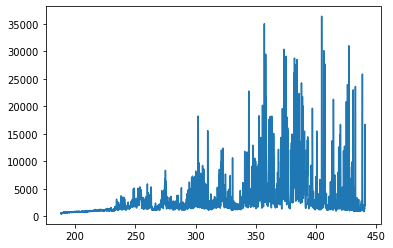

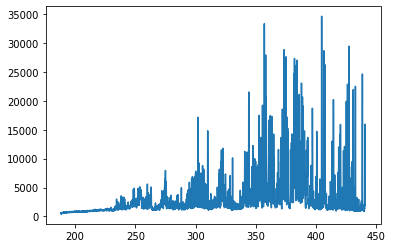

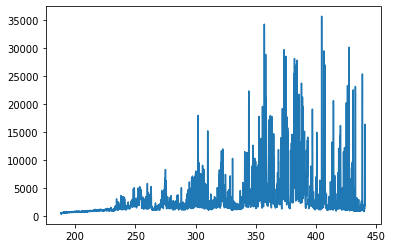

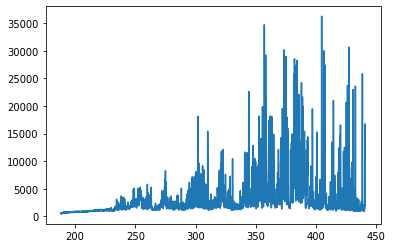

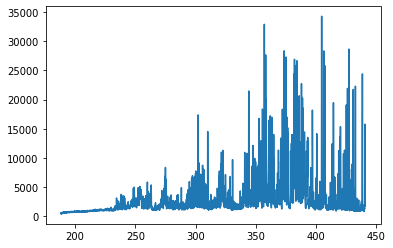

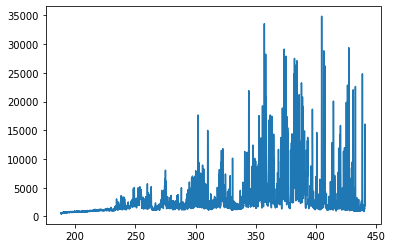

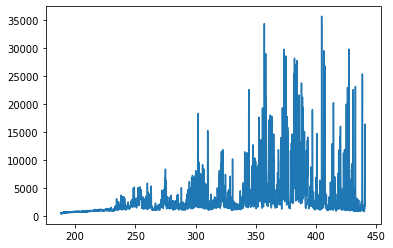

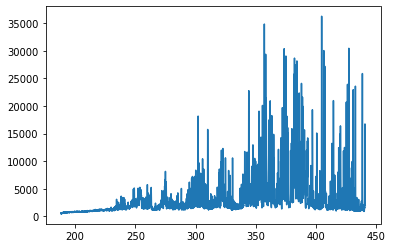

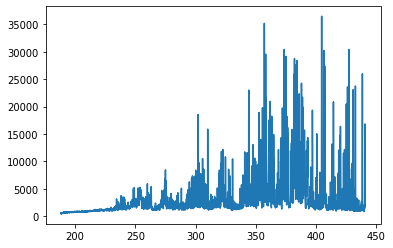

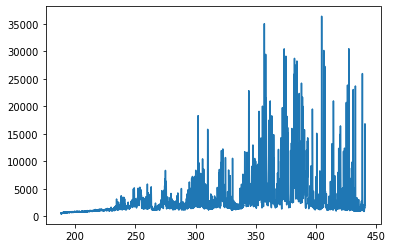

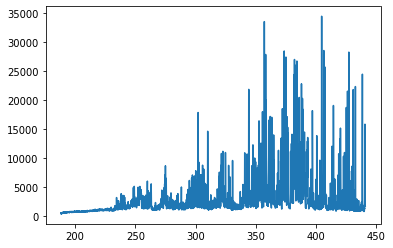

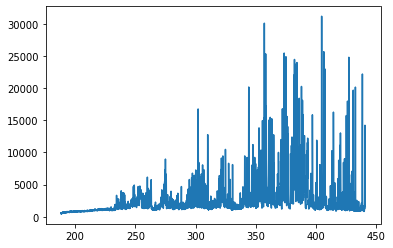

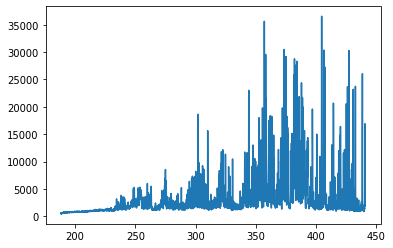

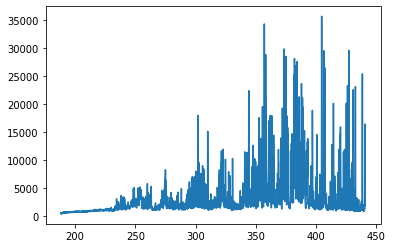

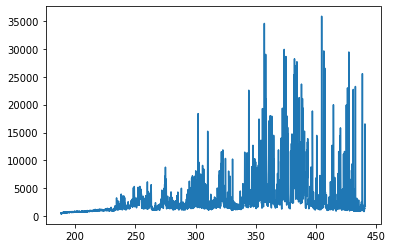

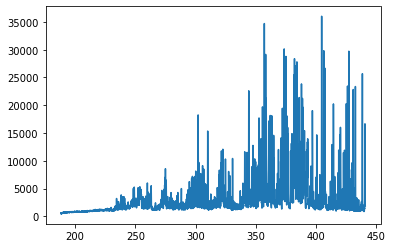

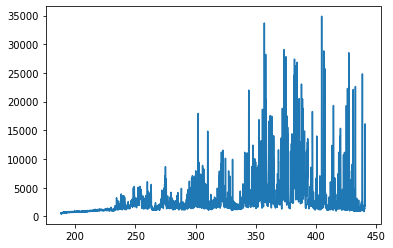

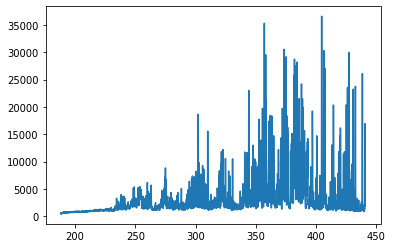

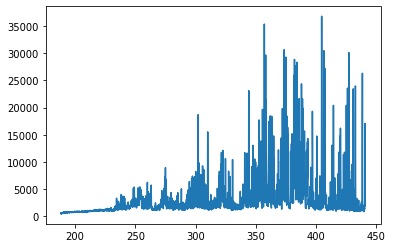

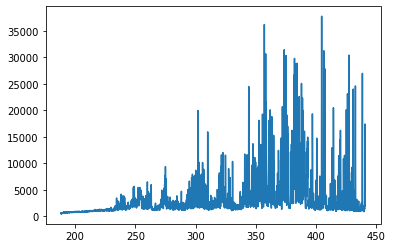

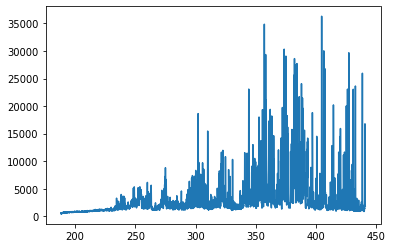

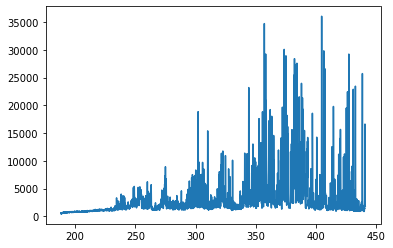

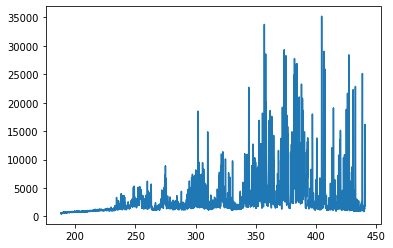

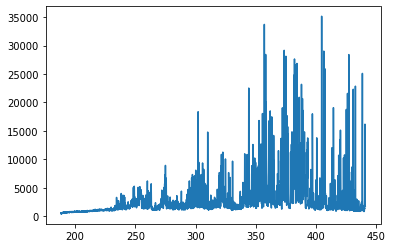

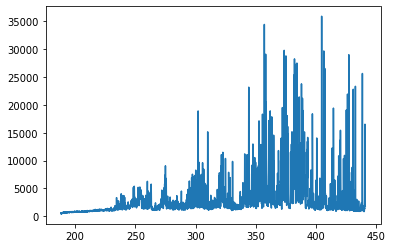

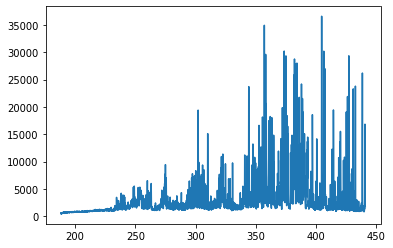

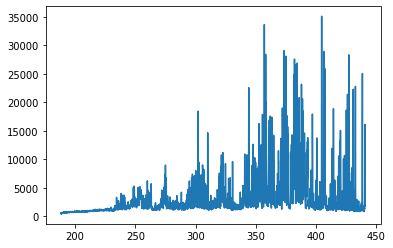

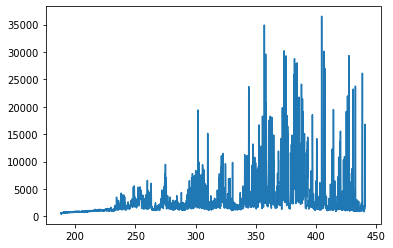

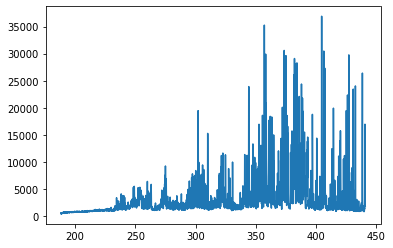

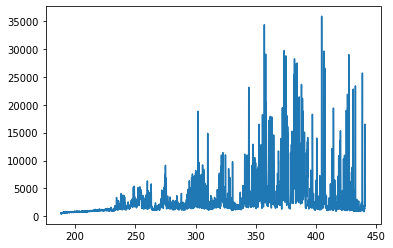

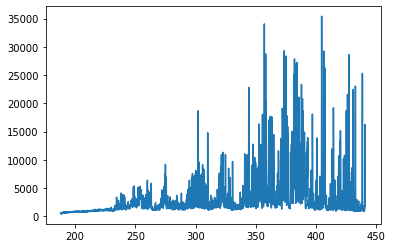

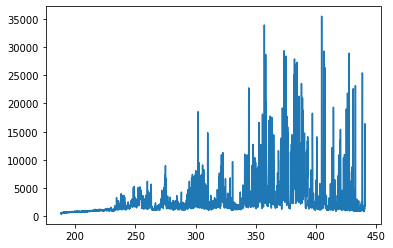

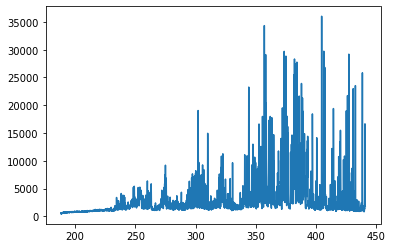

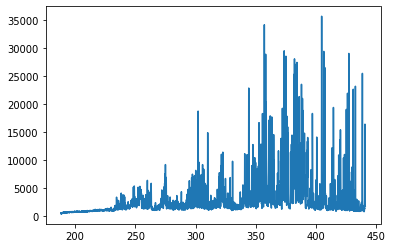

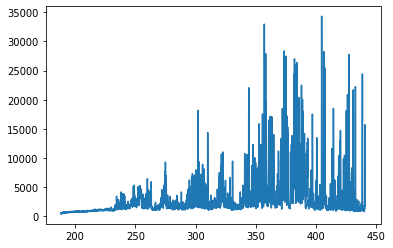

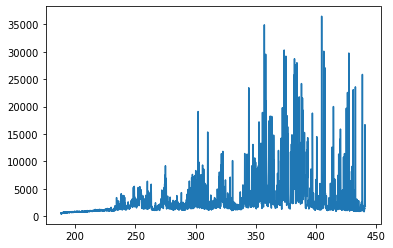

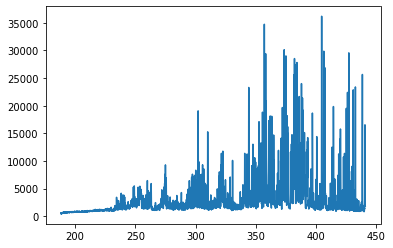

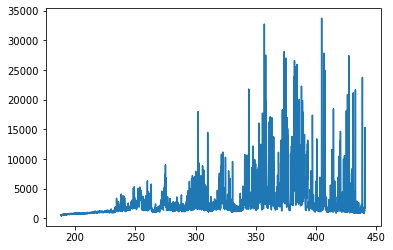

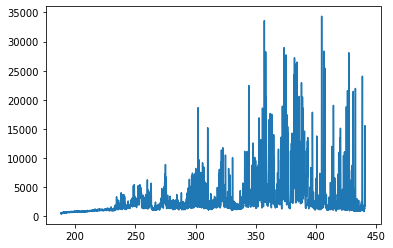

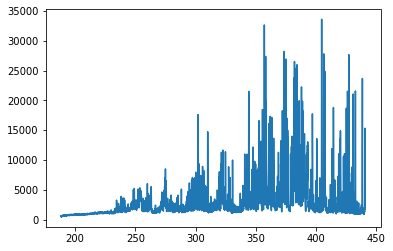

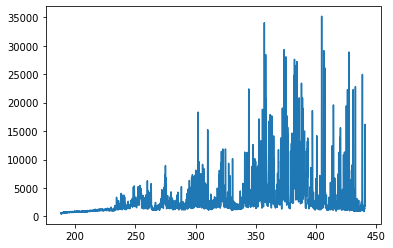

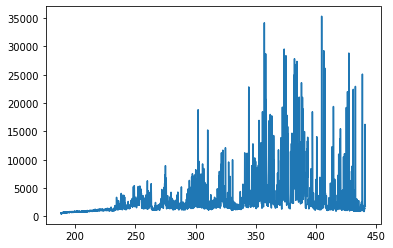

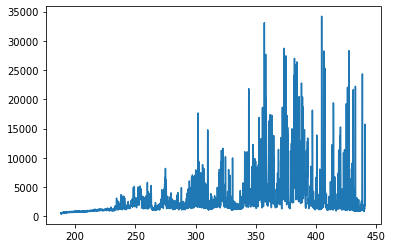

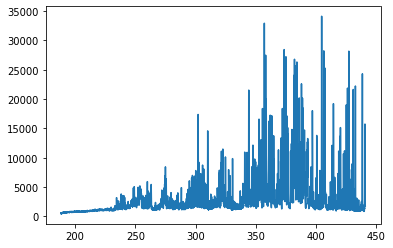

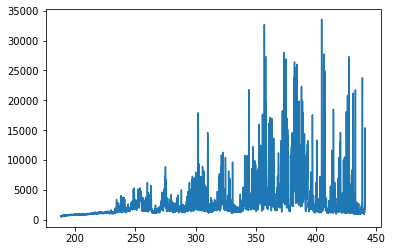

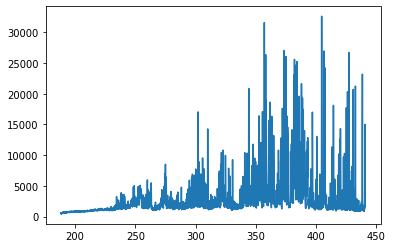

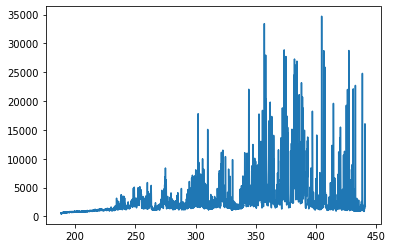

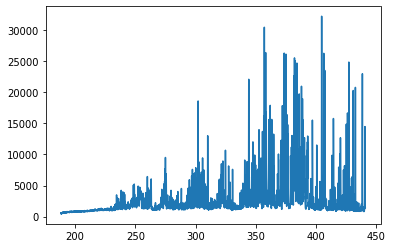

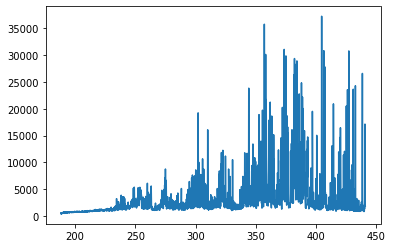

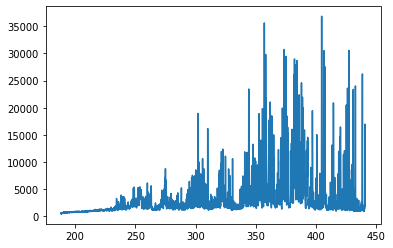

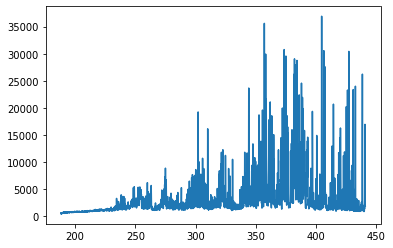

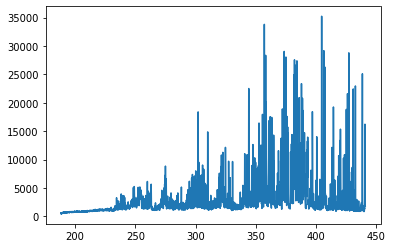

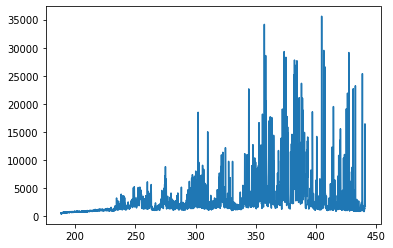

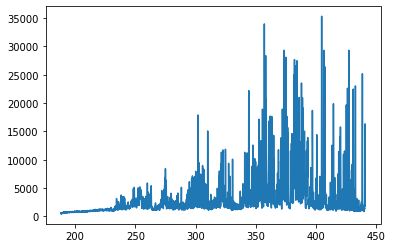

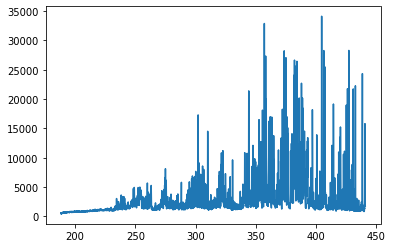

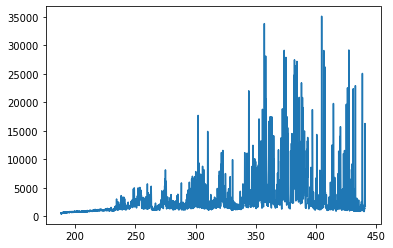

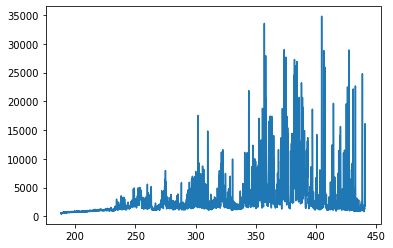

In [188]:
#This is just for visualizing the various plots of the samples

df = pd.read_csv('./data/040_A07_Zanardi_QS277us_200Hz_delay1us_exp1ms', sep = '\t')
df1=df.drop(columns=['Pixels'])
df1=df1.dropna(axis=1)
data=df1.values
wl= data[0]
print(wl)

#for i in range(len(values)):
    #plt.plot(wl, values[i])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))




In [8]:
df_y = pd.read_csv('labels_extended.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

<class 'pandas.core.frame.DataFrame'>
(32051, 7)


In [9]:
y_si = concentration[:,[0,2]]
#print(y_si)
print(y_si.shape)

(32051, 2)


In [10]:
y_si = concentration[:,2]
print(y_si)
print(y_si.shape)

[0.13 0.13 0.13 ... 0.14 0.14 0.14]
(32051,)


In [11]:
df_y_si= pd.DataFrame(y_si)
#df_y_si

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y_si, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(25640, 4094) (25640, 1)
(6411, 4094) (6411, 1)


# Linear Regression
this is ordinary least square regression

In [13]:
from sklearn import linear_model

# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [121]:
b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[2.39 2.4208949875326793]
 [1.5 1.4682738825434019]
 [2.46 2.4889218251166216]
 [2.39 2.3751244613216396]
 [1.5 1.4736024949836781]
 [1.31 1.3496141761761544]
 [1.38 1.417520213479332]
 [2.31 2.328253605406393]
 [1.59 1.5380036339915089]
 [1.38 1.4235789740623503]
 [1.59 1.5347395475895595]
 [1.84 1.8400136162111984]]


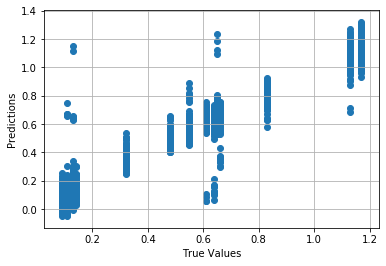

In [14]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [15]:
print ('Score: ', model.score(X_test, y_test))

Score:  0.9603845638860043


In [16]:
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2)

RMSE:  0.06338196937041754
R^2:  0.9603845638860043


# Partial Least Square Regression

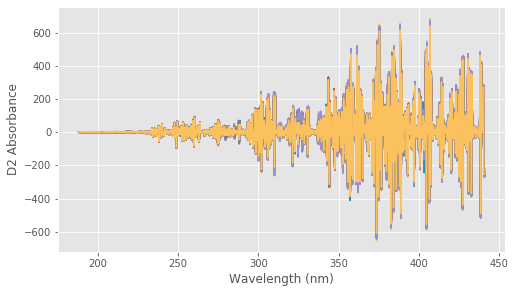

In [35]:
# Calculate second derivative
X2 = savgol_filter(X_train, 17, polyorder = 2,deriv=2) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

In [36]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

100% completed
Suggested number of components:  14



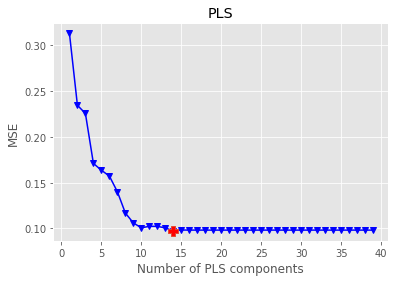

R2 calib: 1.000
R2 CV: 0.771
MSE calib: 0.000
MSE CV: 0.097


In [206]:
optimise_pls_cv(x_df,df_y_si, 40, plot_components=True)

100% completed
Suggested number of components:  13



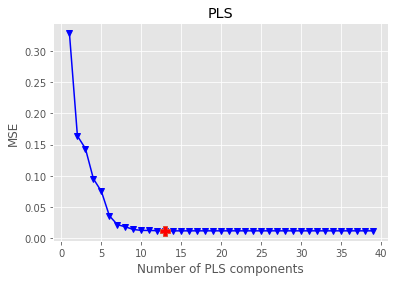

R2 calib: 1.000
R2 CV: 0.971
MSE calib: 0.000
MSE CV: 0.012


In [207]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

In [214]:
# Define PLS object
pls = PLSRegression(n_components=13)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

In [215]:
print("Score: ", score)
print("MSE: ", mse)

Score:  0.9714360966193459
MSE:  0.01193701427031341


In [216]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred)
print(score_cv)

0.9583672164031882
0.9714360966193459


In [217]:
b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[2.27 2.3337516911306997]
 [2.61 2.592772696383902]
 [4.4 4.1142900937227225]
 [2.27 2.2710489635628823]
 [2.27 2.2883790624978415]
 [1.84 1.786786464657291]
 [2.62 2.900504916924585]
 [2.4 2.4509838676128055]
 [1.84 1.8364346835107266]
 [2.42 2.450713834437307]
 [2.54 2.408542735264986]
 [2.46 2.380015450858129]]


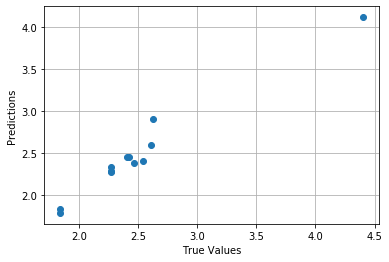

In [218]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [194]:
from sklearn.linear_model import ElasticNet,ElasticNetCV

In [195]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [201]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:1.00, MSE:0.08, RMSE:0.28
Alpha:0.0010, R2:1.00, MSE:0.01, RMSE:0.10
Alpha:0.0100, R2:1.00, MSE:0.00, RMSE:0.03
Alpha:0.1000, R2:1.00, MSE:0.00, RMSE:0.04
Alpha:0.3000, R2:1.00, MSE:0.00, RMSE:0.05
Alpha:0.5000, R2:1.00, MSE:0.00, RMSE:0.05
Alpha:0.7000, R2:1.00, MSE:0.00, RMSE:0.05
Alpha:1.0000, R2:1.00, MSE:0.00, RMSE:0.05


In [221]:
model = ElasticNet(alpha=0.01).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.9998808170459119
RMSE:  0.02979078463933671
R^2:  0.9977271506513161


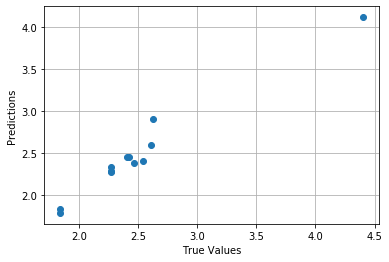

In [222]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# MLP

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Reshape #, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau
from keras.layers.noise import GaussianNoise
from keras.optimizers import Adam
#for CNN
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import normalize, to_categorical

Using TensorFlow backend.


In [46]:
from ChemUtils import GlobalStandardScaler

#xscaler = GlobalStandardScaler()

#X_train = xscaler.fit_transform(dataset['test_1'])
#X_test = xscaler.transform(dataset['calibrate_2'])









NameError: name 'dataset' is not defined

In [28]:
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)
#print(X_test)

In [33]:
DROPOUT = 0.5

# define the keras model
model = Sequential()
model.add(Dense(256, input_dim=4094, activation='relu'))
model.add(Dropout(DROPOUT))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               1048320   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_15 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 1,066,081
Trainable params: 1,065,953
Non-trainable params: 128
________________________________________________________________

In [35]:
opt = Adam(lr=2e-3, decay=1e-3 / 200)
#model.compile(loss="mean_squared_error", optimizer=opt)


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))    
    
#model.compile(optimizer = "opt", loss = root_mean_squared_error, metrics =["accuracy"])

# train the model
print("[INFO] training model...")
model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=64)

[INFO] training model...
Train on 20512 samples, validate on 5128 samples
Epoch 1/200
20512/20512 [==============================] - 12s 565us/step - loss: 0.1020 - val_loss: 0.1018
Epoch 2/200
20512/20512 [==============================] - 10s 509us/step - loss: 0.0986 - val_loss: 0.0987
Epoch 3/200
20512/20512 [==============================] - 11s 531us/step - loss: 0.0961 - val_loss: 0.0944
Epoch 4/200
20512/20512 [==============================] - 10s 506us/step - loss: 0.0934 - val_loss: 0.0920
Epoch 5/200
20512/20512 [==============================] - 10s 484us/step - loss: 0.0888 - val_loss: 0.0868
Epoch 6/200
20512/20512 [==============================] - 10s 489us/step - loss: 0.0833 - val_loss: 0.0797
Epoch 7/200
20512/20512 [==============================] - 10s 488us/step - loss: 0.0772 - val_loss: 0.0737
Epoch 8/200
20512/20512 [==============================] - 11s 515us/step - loss: 0.0710 - val_loss: 0.0669
Epoch 9/200
20512/20512 [==============================] - 10s

20512/20512 [==============================] - 8s 412us/step - loss: 0.0084 - val_loss: 0.0059
Epoch 151/200
20512/20512 [==============================] - 11s 524us/step - loss: 0.0085 - val_loss: 0.0057
Epoch 152/200
20512/20512 [==============================] - 10s 478us/step - loss: 0.0084 - val_loss: 0.0058
Epoch 153/200
20512/20512 [==============================] - 10s 473us/step - loss: 0.0084 - val_loss: 0.0066
Epoch 154/200
20512/20512 [==============================] - 10s 512us/step - loss: 0.0085 - val_loss: 0.0061
Epoch 155/200
20512/20512 [==============================] - 10s 511us/step - loss: 0.0083 - val_loss: 0.0059
Epoch 156/200
20512/20512 [==============================] - 10s 466us/step - loss: 0.0085 - val_loss: 0.0057
Epoch 157/200
20512/20512 [==============================] - 11s 530us/step - loss: 0.0085 - val_loss: 0.0065
Epoch 158/200
20512/20512 [==============================] - 9s 463us/step - loss: 0.0087 - val_loss: 0.0064
Epoch 159/200
20512/20512 

In [ ]:
#rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

#h = model.fit(X_train, y_train, epochs=600, batch_size=8, validation_split=0.2, callbacks=[rdlr], verbose=2)

In [36]:
y_predicted = model.predict(X_test)

# model evaluation
rmse = sqrt(mean_squared_error(y_test, y_predicted))
r2 = r2_score(y_test, y_predicted)
print("RMSE: ", rmse)
print("R^2: ",r2)

RMSE:  0.07322947545965999
R^2:  0.9458633555941282


In [47]:
print(y_test.shape)
print(y_predicted.shape)

print(y_test.values[126])
print(y_predicted[126])

(6411, 1)
(6411, 1)
[0.55]
[0.5307363]


In [38]:
b=np.append(y_test[0], y_predicted[0], axis=1)

print("[real, predictions]")
print(b)

AxisError: axis 1 is out of bounds for array of dimension 1

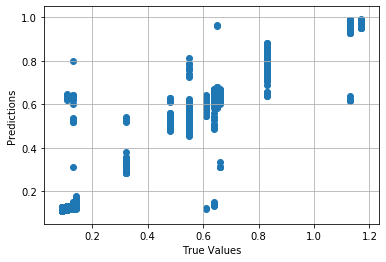

In [48]:
plt.scatter(y_test, y_predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Convolutional Neural Network

In [23]:
#X_train = normalize(X_train, axis=1)
#X_test = normalize(X_test, axis=1)
#print(X_test)
X_test

,188.195100,188.260100,188.325000,188.390000,188.455000,188.520000,188.585000,188.650000,188.714900,188.779900,...,440.300000,440.353000,440.406100,440.459200,440.512300,440.565300,440.618400,440.671400,440.724500,440.777500
1571,0.001731,0.001547,0.001654,0.001464,0.001789,0.001225,0.001612,0.001587,0.001657,0.001593,...,0.009926,0.026495,0.040885,0.053370,0.054433,0.030208,0.013082,0.006857,0.006170,0.005947
17464,0.001834,0.001597,0.001607,0.001398,0.001781,0.001314,0.001669,0.001557,0.001650,0.001625,...,0.009276,0.023971,0.038495,0.050760,0.053550,0.030831,0.013312,0.007097,0.006539,0.006097
4864,0.001683,0.001387,0.001519,0.001416,0.001772,0.001310,0.001598,0.001498,0.001660,0.001519,...,0.009372,0.025038,0.040277,0.053266,0.054891,0.030505,0.013018,0.006881,0.005961,0.006055
21823,0.001930,0.001716,0.001733,0.001531,0.002001,0.001354,0.001816,0.001783,0.001890,0.001790,...,0.009380,0.024795,0.038545,0.050961,0.053096,0.029943,0.013120,0.006880,0.006357,0.005811
21069,0.002012,0.001792,0.001888,0.001702,0.002150,0.001509,0.001819,0.001826,0.001947,0.001792,...,0.009527,0.024333,0.038168,0.051068,0.053091,0.030122,0.013331,0.007105,0.006264,0.006092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14637,0.001724,0.001574,0.001541,0.001415,0.001816,0.001269,0.001589,0.001619,0.001634,0.001601,...,0.009126,0.024297,0.038884,0.051726,0.055038,0.031337,0.013579,0.007184,0.006191,0.005999
27024,0.002317,0.001989,0.002077,0.001797,0.002370,0.001837,0.002297,0.002069,0.002233,0.002113,...,0.009926,0.025416,0.039582,0.051417,0.054571,0.031380,0.013837,0.007245,0.006456,0.006016
7024,0.001883,0.001681,0.001732,0.001537,0.001870,0.001396,0.001735,0.001723,0.001748,0.001723,...,0.009519,0.024898,0.039531,0.052013,0.053754,0.030835,0.013173,0.006887,0.006161,0.006039
14416,0.001979,0.001673,0.001715,0.001518,0.001999,0.001442,0.001778,0.001771,0.001771,0.001682,...,0.009380,0.024035,0.038571,0.051870,0.054145,0.031871,0.013526,0.007267,0.006397,0.006275


In [29]:
#Hyperparameters for the network
DENSE = 128
DROPOUT = 0.5
C1_K  = 8 #Number of kernels/feature extractors for first layer
C1_S  = 32 #Width of the convolutional mini networks
C2_K  = 16
C2_S  = 32

activation='relu'

input_dim = X_train.shape[1]

#The model
def make_model():
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(C1_K, (C1_S), activation=activation, border_mode="same"))
    model.add(Conv1D(C2_K, (C2_S), border_mode="same", activation=activation))
    model.add(Flatten())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])

    return model

In [30]:
model = make_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo (None, 4094)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4094, 1)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4094, 8)           264       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4094, 16)          4112      
_________________________________________________________________
flatten_2 (Flatten)          (None, 65504)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 65504)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8384640   
__________

In [32]:

rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h = model.fit(X_train, y_train, epochs=600, batch_size=64, validation_split=0.2, callbacks=[rdlr], verbose=1)

Train on 20512 samples, validate on 5128 samples
Epoch 1/600
  416/20512 [..............................] - ETA: 8:45 - loss: 0.0872

KeyboardInterrupt: 

In [77]:
y_predicted = model.predict(X_test)

# model evaluation
rmse = sqrt(mean_squared_error(y_test, y_predicted))
r2 = r2_score(y_test, y_predicted)
print("RMSE: ", rmse)
print("R^2: ", r2)

RMSE:  1.2294385384398099
R^2:  -1.4692337033311618


In [75]:
b=np.append(y_test, y_predicted, axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[1.63 1.2509443759918213]
 [2.53 1.2520112991333008]
 [2.4 1.2502681016921997]
 [2.39 1.2502981424331665]
 [2.31 1.251228928565979]
 [1.8 1.2509185075759888]
 [2.62 1.2504569292068481]
 [4.4 1.250625491142273]
 [1.63 1.2513407468795776]
 [1.5 1.2513595819473267]
 [1.8 1.250507116317749]
 [1.38 1.2509829998016357]]


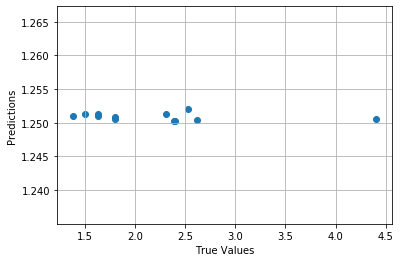

In [76]:
plt.scatter(y_test, y_predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [125]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(12,)
(47,)


In [126]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2300, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [127]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.1


In [128]:
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2)

RMSE:  0.14713379851701522
R^2:  0.8847708596301206


In [129]:
y_test= y_test.reshape((len(y_test), 1))
print(y_test.shape)
print(type(y_test))
predictions=predictions.reshape((len(y_test), 1))
print(predictions.shape)
print(type(y_test))
#print((y_test, predictions))

(12, 1)
<class 'numpy.ndarray'>
(12, 1)
<class 'numpy.ndarray'>


In [130]:
b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[2.39 2.5208826086956324]
 [1.5 1.510573913043496]
 [2.46 2.4505695652174118]
 [2.39 2.420478260869539]
 [1.5 1.6075478260870064]
 [1.31 1.5806391304348275]
 [1.38 1.6764782608696265]
 [2.31 2.326886956521787]
 [1.59 1.6519347826087598]
 [1.38 1.6311608695652753]
 [1.59 1.6288826086957127]
 [1.84 1.84970434782614]]


Text(0, 0.5, 'Predictions')

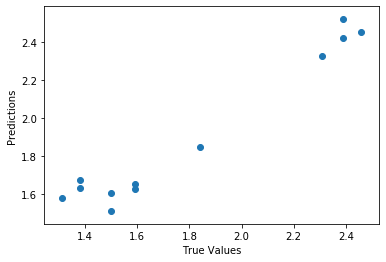

In [131]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [102]:
#I don't remember what's this

#X_train = normalize(X_train, axis=1)
#X_test = normalize(X_test, axis=1)

# MultiOutput Random Forest

In [139]:
multi_y = concentration[:,2:]
#print (multi_y)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [140]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(47, 4094) (47, 7)
(12, 4094) (12, 7)


In [141]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=150,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=150,
                                                

In [142]:
y_multirf = regr_multirf.predict(X_test)

In [143]:
print(y_test.shape)
print(y_multirf.shape)

(12, 7)
(12, 7)


In [144]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  0.9081471005969817
RMSE:  0.09092271675402586


In [145]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[1.8 0.17 0.48 0.37 0.022000000000000002 0.17300000000000001 0.0017 1.69
  0.175 0.508 0.282 0.022 0.232 0.002]
 [2.53 0.13 0.13 0.09300000000000001 0.024 0.012 0.033 2.505 0.127 0.135
  0.139 0.024 0.012 0.035]
 [4.4 0.2 0.14 0.053 0.022000000000000002 0.012 0.0468 3.652 0.178 0.177
  0.07 0.022 0.014 0.047]
 [2.54 0.16 1.13 0.095 0.027000000000000003 0.027000000000000003 0.0568
  2.54 0.171 1.111 0.139 0.026 0.022 0.054]
 [1.59 0.14 0.32 0.06 0.024 0.016 0.001 1.563 0.134 0.256 0.085 0.023
  0.015 0.002]
 [1.5 0.12 0.09 0.04 0.021 0.009000000000000001 0.0009 1.572 0.138 0.231
  0.061 0.022 0.016 0.003]
 [2.49 0.12 0.13 0.11 0.024 0.012 0.036000000000000004 2.522 0.129 0.138
  0.102 0.024 0.013 0.042]
 [2.48 0.12 0.13 0.052000000000000005 0.024 0.012 0.03 2.531 0.134 0.194
  0.1 0.024 0.03 0.044]
 [2.39 0.2 0.65 1.1 0.021 0.267 0.0542 2.426 0.191 0.631 0.987 0.022
  0.266 0.048]
 [1.5 0.12 0.09 0.04 0.021 0.009000000000000001 0.0009 1.558 0.151 0.267
  0.062 0.022

Text(0, 0.5, 'Predictions')

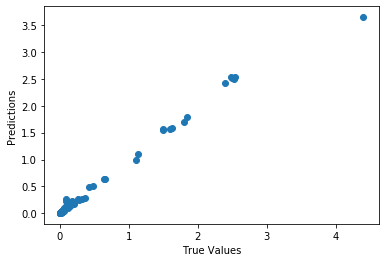

In [146]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [151]:
b=np.append(y_test[0,:],y_multirf[0,:], axis=1)

print("[real, predictions]")
print(b)

TypeError: '(0, slice(None, None, None))' is an invalid key

In [164]:
print(y_test[0]shape)
print(y_multirf[0].T.shape)

(12,)
(7,)


In [184]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([1.69, 2.51, 3.65, 2.54, 1.56, 1.57, 2.52, 2.53, 2.43, 1.56, 1.8 ,
       1.58])

In [185]:
y_test[0].values

array([1.8, 2.53, 4.4, 2.54, 1.59, 1.5, 2.49, 2.48, 2.39, 1.5, 1.84, 1.63],
      dtype=object)

In [186]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [1.8 2.53 4.4 2.54 1.59 1.5 2.49 2.48 2.39 1.5 1.84 1.63]
pred:  [1.69 2.51 3.65 2.54 1.56 1.57 2.52 2.53 2.43 1.56 1.8  1.58]
